## 데이터 불러오기

In [111]:
import os

data_path = os.getenv('HOME')+'/repo/Aiffel/Project/Exploration/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


### 시각화하기

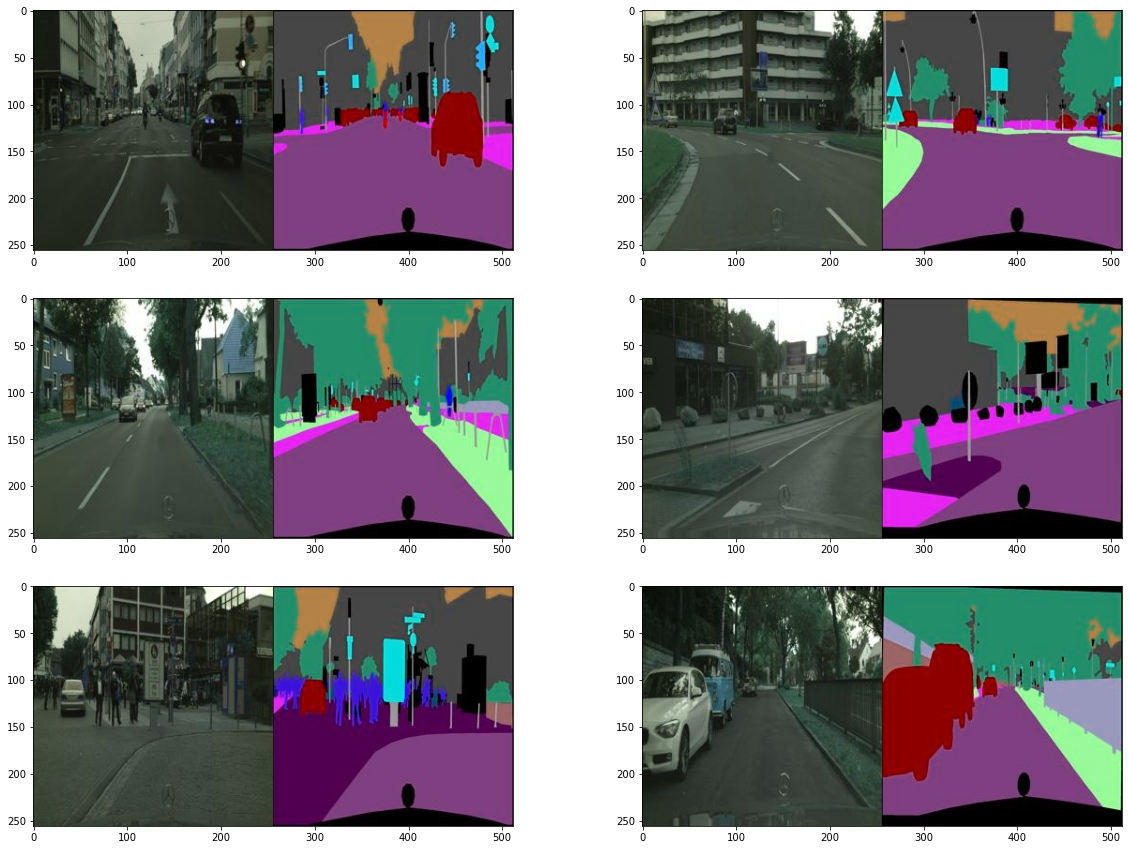

In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [113]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


다운 받은 이미지는 두장의 사진이 붙어있습니다.  
input 이미지와 target 이미지로 분리하기 위해 가운데를 잘라줄 필요가 있습니다. 

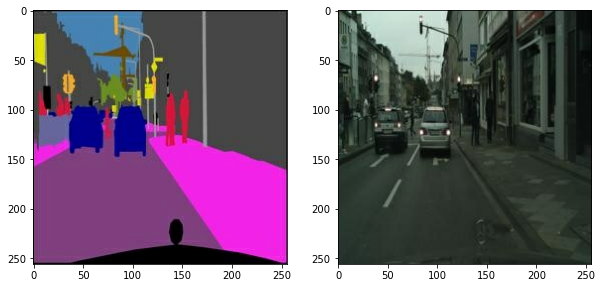

In [114]:
import tensorflow as tf

def normalize(x):
    '''이미지를 정규화 하는 함수'''
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    '''시각화를 위해서 다시 복원하는 함수'''
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    '''이미지를 load하는 함수, shape의 width를 1/2한 값으로 갈라준다'''
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    segment = img[:, w:, :] 
    segment = tf.cast(segment, tf.float32)
    city = img[:, :w, :] 
    city = tf.cast(city, tf.float32)
    return normalize(segment), normalize(city)

f = data_path + os.listdir(data_path)[1]
segment, city = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(segment))
plt.subplot(1,2,2); plt.imshow(denormalize(city))

width를 기준으로 딱 절반으로 잘라주었습니다. 

## Data Augmentation

data augmentation에서는 총 2가지의 기법을 사용해서 비교를 할 예정입니다.  
1. tensorflow.image 를 활용한 augmentation
2. cutmix를 활용한 augmentation

### Tensoflow.image 활용

In [115]:
# Augmentation 사용하기
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# 빠른 tensor 연산을 위한 데코
@tf.function() 
def apply_augmentation(segment, city):
    ''' augmentation을 적용하는 함수
        random_pad
        random_crop
        random_flip'''
    
    stacked = tf.concat([segment, city], axis=-1)
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

먼저 tensorflow.image를 활용하여 augmentation을 적용하겠습니다.  
segment 이미지와 sity 이미지에 같은 모양을 만들기 위해 concat을 한 이미지를 처리하고 return 시에 분리하겠습니다.

1. reflect 혹은 constant 패드 추가
2. 대상 크기를 랜덤으로 자르기
3. 이미지를 가로로 랜덤으로 뒤집기
3. 이미지를 세로로 랜덤으로 뒤집기

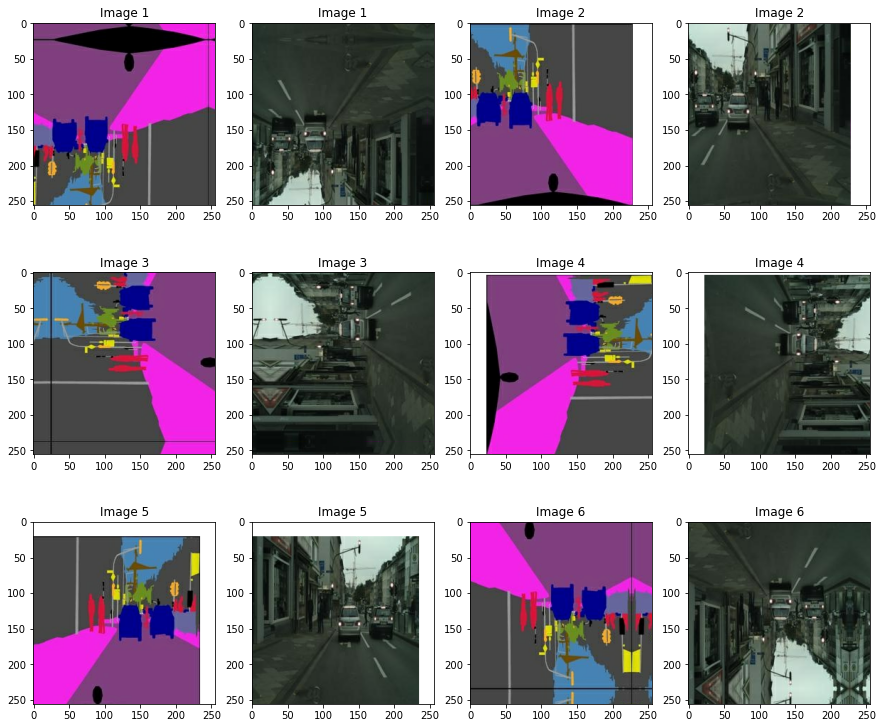

In [116]:
# augmentation 적용 이미지 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = apply_augmentation(segment, city)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city)); plt.title(f"Image {img_n}")
    img_n += 1

제대로 augmentation이 적용된 모습을 확인 할 수 있습니다.  
padd가 CONSTANT라면 흰색으로 보이는 부분으로 채워지고, padd가 REFLECT라면 반전된 성분이 붙여집니다.

### Cutmix 활용

In [117]:
@tf.function() 
def cutmix(segment, city, batch_size=2, img_size=256):
    ''' 입력: segment, city 이미지 리스트,
        파라미터: batch_size, img_size,
        서로 다른 두개의 이미지 리스트를 받아서 cutmix해준다.'''
    mixed_citys = []
    mixed_aurgs = []
    image = tf.concat([segment, city], axis=-1)
    
    for i in range(batch_size):
        image_a = image[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        
        mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
        mixed_citys.append(mixed_img[...,:3])
        mixed_aurgs.append(mixed_img[...,3:])
        
    mixed_city = tf.reshape(tf.stack(mixed_citys),(batch_size, img_size, img_size, 3))
    mixed_aurg = tf.reshape(tf.stack(mixed_aurgs),(batch_size, img_size, img_size, 3))                      
    return mixed_city, mixed_aurg

def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=256):
    '''서로 다른 두 이미지 a, b가 있다면 a의 이미지에 crop된 b이미지를 붙여준다.'''
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def get_clip_box(image_a, image_b, img_size=256):
    '''랜덤으로 박스의 위치 좌표를 출력한다.'''
    x = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    y = tf.cast( tf.random.uniform([],30, img_size-30),tf.int32)
    
     # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

그 다음 cutmix를 활용하기 위해 함수를 정의 했습니다.  
함수는 다음과 같이 진행됩니다.  
1. segment 이미지와 city 이미지 concat
2. 이미지 내에서 임의의 박스 좌표 추출
3. 서로 다른 두 concat된 이미지를 crop하여 합쳐준다.

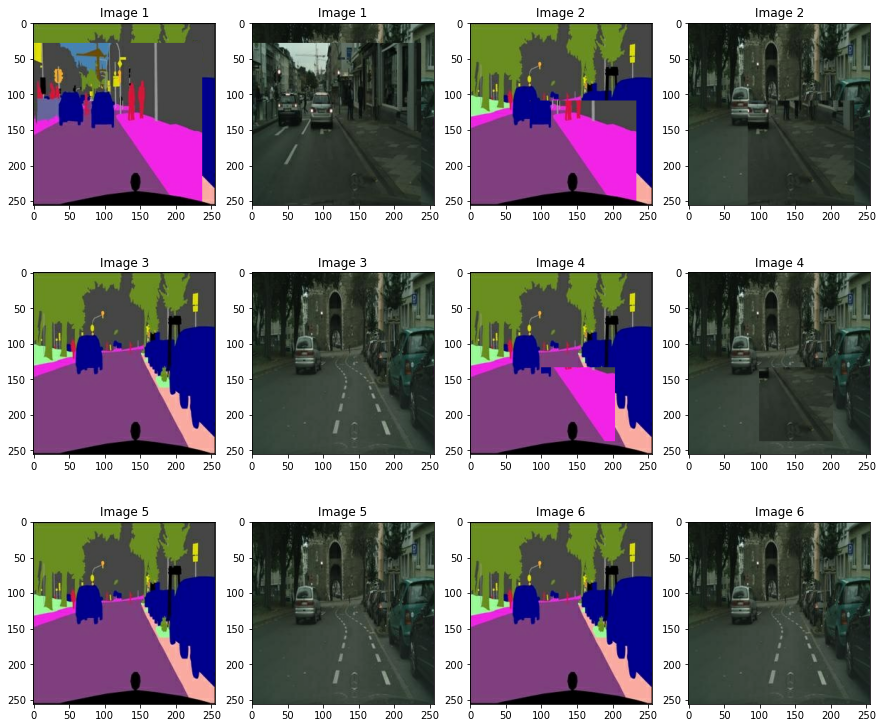

In [118]:
f = data_path + os.listdir(data_path)[1]
s = data_path + os.listdir(data_path)[2]
segment1, city1 = load_img(f)
segment2, city2 = load_img(s)
segment = [segment1, segment2]
city = [city1, city2]

# augmentation 적용 이미지 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_segment, augmented_city = cutmix(segment, city)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_segment[1])); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_city[1])); plt.title(f"Image {img_n}")
    img_n += 1

image 1, 2, 4 를 보면 잘 적용되었음을 볼 수 있습니다.

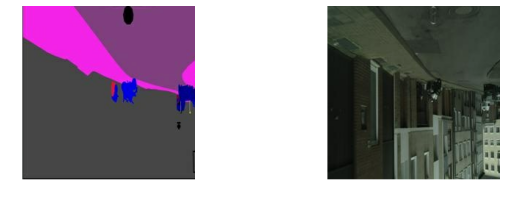

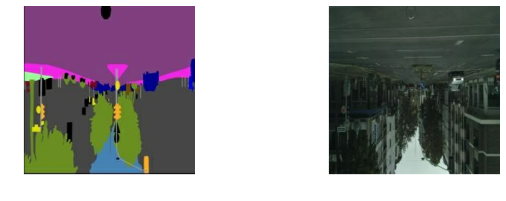

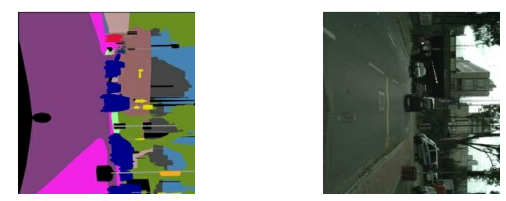

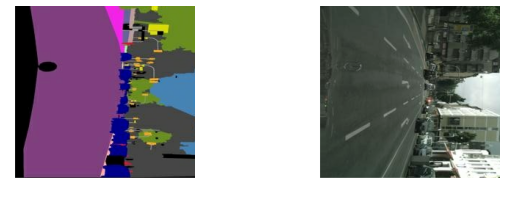

In [119]:
# 학습 데이터에 적용 시켜보기
from tensorflow import data

def get_train(ds, with_aug=False, with_cutmix=False):
    ds = ds.map(
            load_img 
        )
    if with_aug:
        ds = ds.map(
            apply_augmentation
        )
    if with_cutmix:
        ds = ds.batch(2)
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

image_path = data.Dataset.list_files(data_path + "*.jpg")
train_images = get_train(image_path, with_aug=True).shuffle(100).batch(4)
#train_images = get_train(image_path, with_cutmix=True).shuffle(100)
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
segment, city = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

for i in range(4):
    plt.figure(figsize=(10,20))
    plt.subplot(5,2,i*2+1); plt.imshow(segment[i].astype(np.uint8));plt.axis('off')
    plt.subplot(5,2,(i+1)*2); plt.imshow(city[i].astype(np.uint8));plt.axis('off')

우리가 train할 데이터에도 augmentation이 잘 적용되었습니다.

## 모델 생성

### pix2pix cGAN Generator 구성하기

In [82]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [83]:
Encoder().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_64 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_65 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_66 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_67 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_68 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_69 (EncodeBlock (None, 4, 4, 512)         4196

### Decoder 만들기

In [84]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [85]:
Decoder().get_summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_56 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_57 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_58 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_59 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_60 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_61 (DecodeBlock (None, 64, 64, 128)       5248

### U-Net Generator

In [86]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [87]:
UNetGenerator().get_summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_72 (EncodeBlock)   (None, 128, 128, 64) 3072        input_13[0][0]                   
__________________________________________________________________________________________________
encode_block_73 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_72[0][0]            
__________________________________________________________________________________________________
encode_block_74 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_73[0][0]            
___________________________________________________________________________________________

### Discriminator 구현하기

In [88]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [89]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [90]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_36 (Concatenate)    (None, 256, 256, 6)  0           input_14[0][0]                   
                                                                 input_15[0][0]                   
__________________________________________________________________________________________________
disc_block_40 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_36[0][0]      

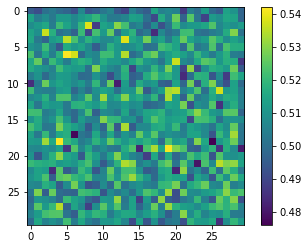

In [103]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 학습 및 테스트하기

In [104]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [105]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [123]:
@tf.function
def train_step(segment, real_city):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_city = generator(segment, training=True)
        # Discriminator 예측
        fake_disc = discriminator(segment, fake_city, training=True)
        real_disc = discriminator(segment, real_city, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_city, real_city, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [124]:
EPOCHS = 10

aug_history = {'g_loss': [] , 'l1_loss': [], 'd_loss': []}

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (segment, city) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(segment, city)
                
    aug_history['g_loss'].append(g_loss.numpy())
    aug_history['l1_loss'].append(l1_loss.numpy())
    aug_history['d_loss'].append(d_loss.numpy())

    print(f"EPOCH[{epoch}] \
            \nGenerator_loss:{g_loss.numpy():.4f} \
            \nL1_loss:{l1_loss.numpy():.4f} \
            \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1]             
Generator_loss:0.7641             
L1_loss:0.2172             
Discriminator_loss:0.9985

EPOCH[2]             
Generator_loss:1.6293             
L1_loss:0.1454             
Discriminator_loss:1.2119

EPOCH[3]             
Generator_loss:2.0350             
L1_loss:0.1577             
Discriminator_loss:0.6039

EPOCH[4]             
Generator_loss:1.9977             
L1_loss:0.1636             
Discriminator_loss:1.1437

EPOCH[5]             
Generator_loss:1.0147             
L1_loss:0.2067             
Discriminator_loss:0.6707

EPOCH[6]             
Generator_loss:1.5906             
L1_loss:0.1597             
Discriminator_loss:0.6281

EPOCH[7]             
Generator_loss:0.2544             
L1_loss:0.1885             
Discriminator_loss:1.7950

EPOCH[8]             
Generator_loss:2.2603             
L1_loss:0.1823             
Discriminator_loss:0.3848

EPOCH[9]             
Generator_loss:1.8528             
L1_loss:0.1494             
Discriminator_loss:

## Summary

In [127]:
test_path = os.getenv('HOME')+'/repo/Aiffel/Project/Exploration/data/cityscapes/val/'

### 첫 번째 시도

#### tf.image를 사용한 augmentation

(-0.5, 255.5, 255.5, -0.5)

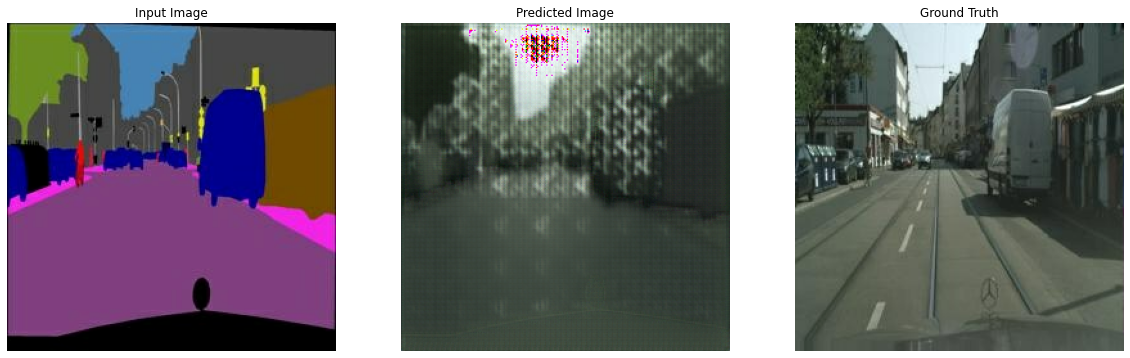

In [128]:
test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

### 두번째 시도

#### cutmix를 사용한 augmentation

(-0.5, 255.5, 255.5, -0.5)

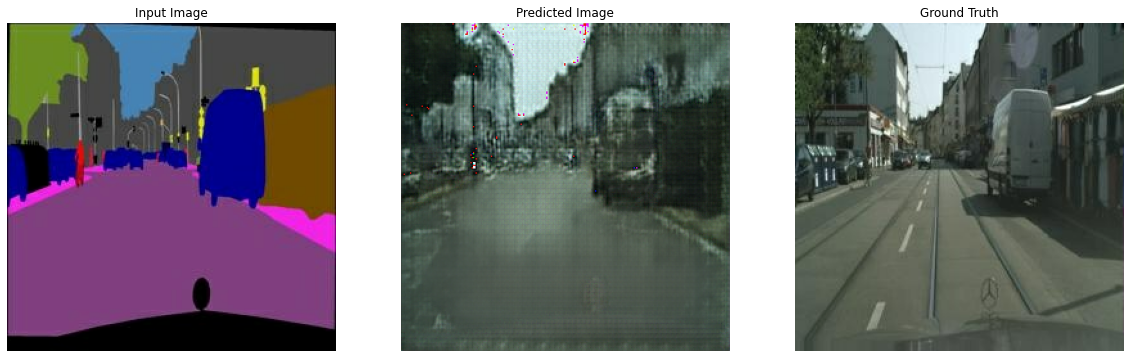

In [73]:
test_ind = 1

f = test_path + os.listdir(test_path)[test_ind]
segment, city = load_img(f)

pred = generator(tf.expand_dims(segment, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(segment)); plt.title('Input Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denormalize(city));  plt.title('Ground Truth'); plt.axis('off')

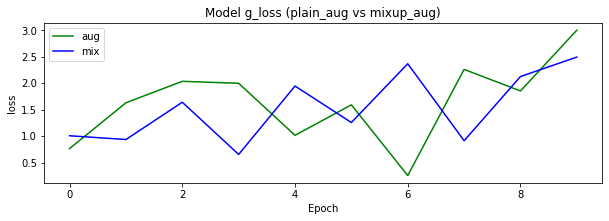

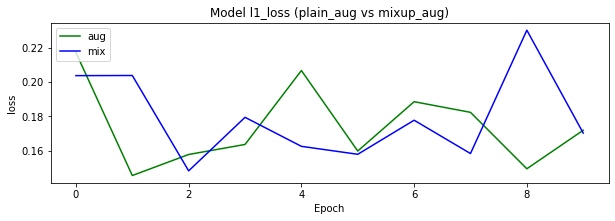

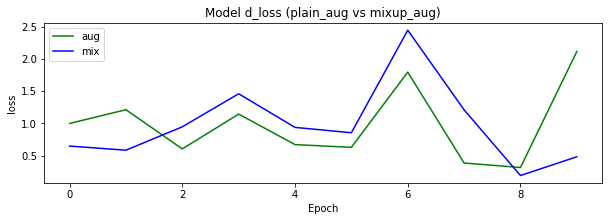

In [129]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(aug_history['g_loss'], 'g')
plt.plot(mix_history['g_loss'], 'b')
plt.title('Model g_loss (plain_aug vs mixup_aug)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.plot(aug_history['l1_loss'], 'g')
plt.plot(mix_history['l1_loss'], 'b')
plt.title('Model l1_loss (plain_aug vs mixup_aug)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.plot(aug_history['d_loss'], 'g')
plt.plot(mix_history['d_loss'], 'b')
plt.title('Model d_loss (plain_aug vs mixup_aug)')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['aug', 'mix'], loc='upper left')

#### predicted 이미지와 loss 그래프 분석
사진으로 보기에는 tensorflow.image를 사용한 augmentation보다 cutmix를 사용한 augmentation 결과가 더 잘 나온 것 같습니다.  
하지만 그래프를 비교해보니 loss에서는 별반 차이가 없어 보입니다.  
왜 이런 결과가 나왔을까?  
예상하기에는 사람이 직관적으로 평가하는 지표와 모델 평가 방법이 조금 다른 듯 합니다.  
좀 더 좋은 성능을 내기 위해서는 평가 지표를 수정할 필요가 있어보입니다.